<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative27092021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px
import cv2 as cv

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.6.0


In [3]:
# Instalar Tensorflow
#!pip install tensorflow==2.6.0

In [4]:
# Instalar Keras
!pip install keras --upgrade

In [5]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/

# **Coleta de dados do Kaglle**

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **###  Download dos dados / descompactando os dados**

In [8]:
!kaggle datasets download fabiobasson/geologicalsimilarity
! unzip -qq  geologicalsimilarity

  0% 0.00/1.31M [00:00<?, ?B/s]
100% 1.31M/1.31M [00:00<00:00, 43.8MB/s]


# ** Criação da estrutura e leitura de diretórios **

In [9]:
andesite_dir = glob.glob('andesite/*.jpg');gneiss_dir = glob.glob('gneiss/*.jpg')
marble_dir= glob.glob('marble/*.jpg');quartzite_dir = glob.glob('quartzite/*.jpg')
rhyolite_dir = glob.glob('rhyolite/*.jpg');
schist_dir = glob.glob('schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


230
190
204
198
198
204


# **Nomes das Classes**
# andesite = 0  # gneiss =1 # marbler = 2 # quartzite = 3 # rhyolite = 4  # schist = 5 


In [10]:
label = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']

#label =[0,1,2,3,4,5]

In [11]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,label[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label[1]])
for l in marble_dir:
    marble_df.append([l,label[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label[4]])
for o in schist_dir:
    schist_df.append([o,label[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

1218

# **Criação do Dataframe**

In [12]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,andesite/1A9NT.jpg,andesite
1,gneiss/0K1FK.jpg,gneiss
2,marble/0EWTD.jpg,marbler
3,andesite/0GI41.jpg,andesite
4,andesite/0ZAU9.jpg,andesite
...,...,...
1213,schist/1UPGE.jpg,schist
1214,gneiss/1LB4G.jpg,gneiss
1215,rhyolite/1OY0U.jpg,rhyolite
1216,marble/1JAC8.jpg,marbler


#  Conhecendo os dados de imagem

uint8
(28, 28, 3)
251
32


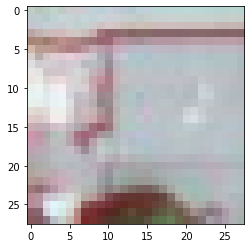

In [13]:
from matplotlib import image
from matplotlib import pyplot
# Carregando imagem como um array NumPy:
data = image.imread("gneiss/0QTQE.jpg")
# Imprimindo as propriedades do array de pixels:
print(data.dtype)
print(data.shape)
print(data.max())
print(data.min())

# Exibindo o array de pixels como uma imagem:
pyplot.imshow(data)

In [14]:
from numpy import asarray
image = Image.open("gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

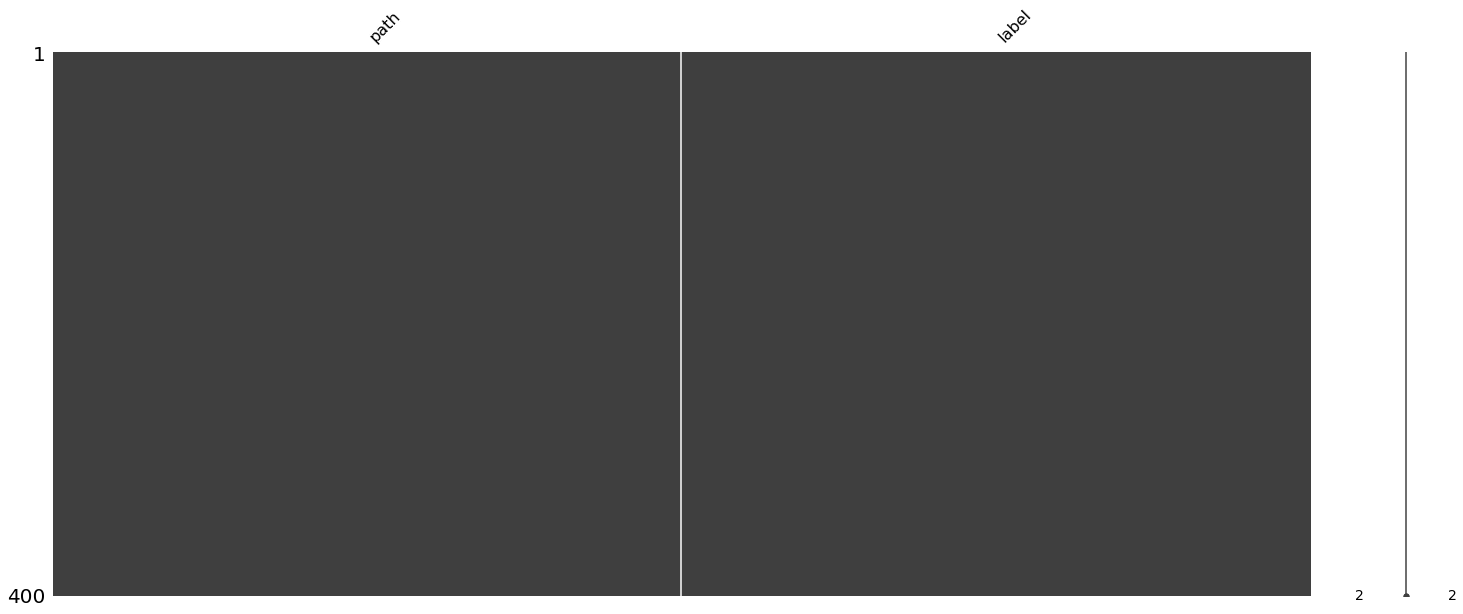

In [15]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [16]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Separação das amostras**

In [17]:
X = data_df.drop(columns='label')
y = data_df.label

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [18]:
IMG_SHAPE = 28
IMG_SHAPE_V3 = 75

BATCH_SIZE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [19]:
datagen_train = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

train_generator = datagen_train.flow_from_dataframe(data_df,
                                              batch_size=BATCH_SIZE,
                                              x_col='path',
                                              y_col= 'label',
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                              #class_mode='raw',
                                              subset='training')

datagen_val = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2 )

validation_generator = datagen_val.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=True,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   #class_mode='raw',
                                                   subset='validation')    

Found 975 validated image filenames belonging to 6 classes.
Found 243 validated image filenames belonging to 6 classes.


In [20]:
train_generator_inceptionv3 = datagen_train.flow_from_dataframe(data_df,
                                              batch_size=BATCH_SIZE,
                                              x_col='path',
                                              y_col= 'label',
                                              shuffle=True,
                                              target_size=(IMG_SHAPE_V3,IMG_SHAPE_V3),
                                              #class_mode='raw',
                                              subset='training')


validation_generator_inceptionv3 = datagen_val.flow_from_dataframe(data_df,
                                                   batch_size=BATCH_SIZE,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=True,
                                                   target_size=(IMG_SHAPE_V3,IMG_SHAPE_V3),
                                                   #class_mode='raw',
                                                   subset='validation')  

Found 975 validated image filenames belonging to 6 classes.
Found 243 validated image filenames belonging to 6 classes.


In [21]:
datagen_test = ImageDataGenerator(rescale=1./255,
                                  )

test_generator = datagen_val.flow_from_dataframe(data_df,
                                                 batch_size=BATCH_SIZE,
                                                 x_col='path',
                                                 y_col='label',
                                                 shuffle=True,
                                                 #class_mode='raw',
                                                 target_size=(IMG_SHAPE,IMG_SHAPE))                                                   

Found 1218 validated image filenames belonging to 6 classes.


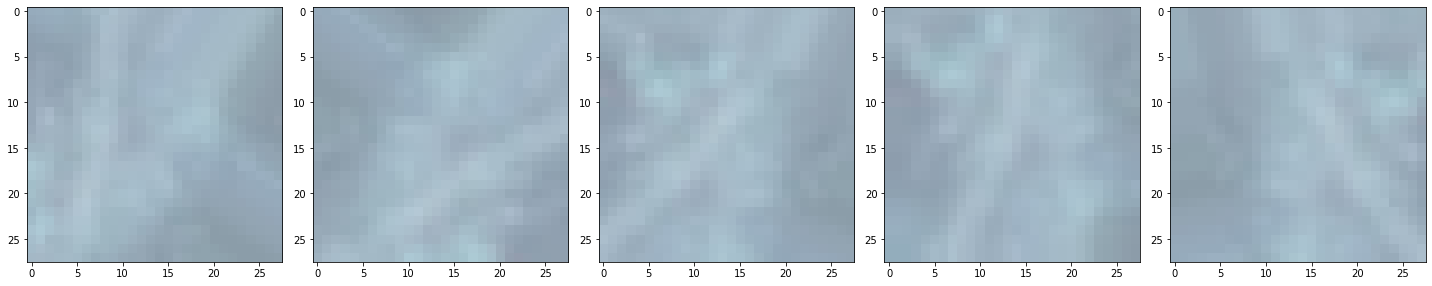

In [22]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Criando o Dataframe em dados de treino, validação e teste**

In [23]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

X_test.shape

(32, 28, 28, 3)

# **Criar o modelo**

In [24]:
classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
   
])

# **Compilando o Modelo**

In [25]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0

In [26]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

# **Avaliar o modelo**

In [27]:
epochs=100
history = model.fit(train_generator,
                               epochs=epochs,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/100
31/31 [==============================] - 34s 54ms/step - loss: 1.6271 - accuracy: 0.4031 - val_loss: 1.7627 - val_accuracy: 0.1646
Epoch 2/100
31/31 [==============================] - 2s 50ms/step - loss: 1.1706 - accuracy: 0.6154 - val_loss: 1.7099 - val_accuracy: 0.2099
Epoch 3/100
31/31 [==============================] - 2s 52ms/step - loss: 0.7917 - accuracy: 0.7128 - val_loss: 1.6332 - val_accuracy: 0.2346
Epoch 4/100
31/31 [==============================] - 1s 40ms/step - loss: 0.6625 - accuracy: 0.7497 - val_loss: 1.5466 - val_accuracy: 0.3045
Epoch 5/100
31/31 [==============================] - 1s 42ms/step - loss: 0.5924 - accuracy: 0.7754 - val_loss: 1.4600 - val_accuracy: 0.4198
Epoch 6/100
31/31 [==============================] - 2s 42ms/step - loss: 0.5332 - accuracy: 0.7928 - val_loss: 1.3456 - val_accuracy: 0.5021
Epoch 7/100
31/31 [==============================] - 1s 40ms/step - loss: 0.5129 - accuracy: 0.7969 - val_loss: 1.2459 - val_accuracy: 0.5885
Epoch

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

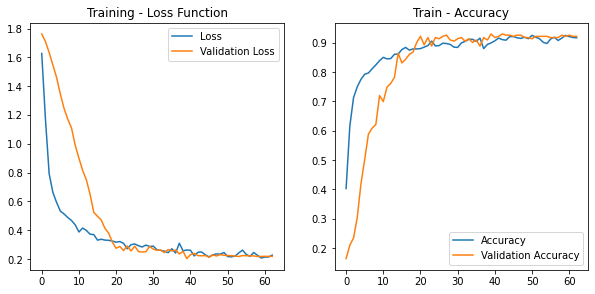

In [28]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

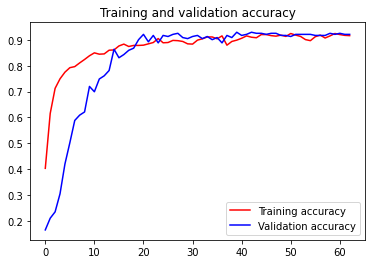

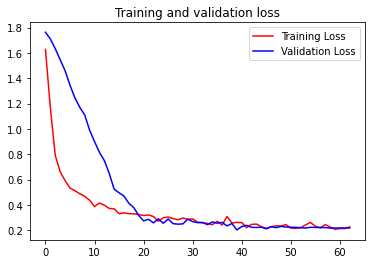

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [4]:
history2= model.history.history
px.line(history2,title = "Metrics Plot")

NameError: ignored

# **Otimizar o modelo**

# **Avaliar acurácia  do Modelo**

In [5]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

NameError: ignored

# **Listando as redes realmente disponíveis em seu Keras**

In [32]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**

In [33]:
# Inicializar a CNN
classifier = VGG16(include_top=False, input_shape=(32, 32, 3)) # Minimo de shape que o VGG16 aceita

# marcar camadas como não treináveis
for layer in classifier.layers:
    layer.trainable = False

# adicionar novas camadas para classificação
flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)

# definir o modelo
modelvgg16 = Model(inputs=classifier.inputs, outputs=output)

modelvgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [34]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]


In [ ]:
epochs=100
historyvgg16 = modelvgg16.fit(train_generator,
                         steps_per_epoch = 975/32,
                          epochs=epochs,
                          callbacks=callbacksvgg16,
                          #validation_steps = 2000/32,
                          validation_data=validation_generator)

Epoch 1/100


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

# **O modeo InceptionV3**

In [ ]:
#inception_v3 = InceptionV3(input_shape=(150, 150, 3),
                           #weights='imagenet',
                           #include_top=False)
#inception_v3.trainable = False

In [ ]:
inception_v3 = InceptionV3(include_top=False, input_shape=(75, 75, 3)) 

# marcar camadas como não treináveis
for layer in inception_v3.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(inception_v3.layers[-1].output)
x = layers.Rescaling(1./255)(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(6, activation='softmax')(x)

#x = layers.Flatten()(inception_v3.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(512,activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(6,activation='softmax')(x)           

# definir o modelo
modelinception_v3 = Model(inputs=inception_v3.input, outputs=output) 

modelinception_v3.summary()

In [ ]:
modelinception_v3.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])

callbacksinception_v3 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [ ]:
epochs=100

historyv3 = modelinception_v3(train_generator_inceptionv3,
                               #steps_per_epoch = 975/32,
                               epochs=epochs,
                               callbacks=callbacksinception_v3,
                               validation_data=validation_generator_inceptionv3)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
modelinception_v3 = tf.keras.models.load_model("inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

test_lossinception_v3, test_accinception_v3= modelinception_v3.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvinception_v3))

# **Fim do modelo Inception V3**

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc,val_acvgg16c,val_accInceptionV3,valaccEfficientNetB,valaccEfficientNetB7]
model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()

# **Realizar a Predição para as 6 classes**

In [ ]:
predictions = model.predict(X_test)
print("Prediction_accuracy: " + str(predictions))

In [ ]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Escalaremos esses valores no intervalo de 0 e 1 antes antes de alimentar o modelo da rede neural. Para fazer isso, dividimos os valores por 255. É importante que o conjunto de treinamento e o conjunto de teste podem ser pré-processados do mesmo modo:

In [ ]:
X_train = X_train /255
X_test = X_test /255

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(label[y_train[i]])
plt.show()

In [ ]:
# Codigo do Dr.(o)professor Leonardo Forero

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(label[predicted_label],
                                100*np.max(predictions_array),
                                label[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)
plt.show()

In [ ]:
predictions[0] # primeira predição

In [ ]:
np.argmax(predictions[0])

In [ ]:
predictions = np.argmax(predictions)
predictions

In [ ]:
y_test[0]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_test,str(predictions))

In [ ]:
img_pred = cv.imread("gneiss/0QTQE.jpg",0)
plt.imshow(img_pred)

In [ ]:
if img_pred.shape != [28,28]:
    img2 = cv.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)

img_pred = ~img_pred
img_pred = img_pred.reshape(1, 1, 28, 28).astype('float32')

img_pred = img_pred/255.0


In [ ]:
pred = model.predict(img_pred)
pred_proba = model.predict_proba(img_pred)


In [ ]:
pred_proba = "%.2f%%" % (pred_proba[0][pred]*100)
print(pred[0], " com confiança de ", pred_proba)